In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.gridspec as gridspec
import sklearn.cluster as skcl
from swarmDMD_functions import *
from os import path
from scipy.optimize import curve_fit
from scipy.stats import linregress
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import csv
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
# Loading and processing functions go here
def load_data(N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling):
    # full load_data call:
    # X_GT3d,dt,v_truth,TN,X_GT,D_GT,P_GT_temp,Mang_GT_temp,Mabs_GT,mean_bin_GT,mean_bin_GT_P,X_DMD,D_DMD,P_DMD_temp,Mang_DMD_temp,Mabs_DMD,mean_bin_DMD,mean_bin_DMD_P,num_bins,bin_width,bin_freq = load_data(simplified,N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling)
    
    if milling == 1:
        millname = '_milling'
        millnameDMD = '_milling'
        N_GT = N
    else:
        millname = ''
        millnameDMD = ''
        N_GT = N
        
    filenameGT = 'vicsek'+millname+'_N'+str(N_GT)+'_eta'+eta_name+'_W'+str(wide)+'_rho'+str(rho)+'_r'+r_name
    filenameGTAnalysis = 'vicsekAnalysis'+millnameDMD+'_N'+str(N)+'_eta'+eta_name+'_W'+str(wide)+'_rho'+str(rho)+'_r'+r_name+'_Focal'+str(F)
    findnameDMD = 'swarmDMD_datatype'+str(datatype)+'_N'+str(N)+'_eta'+eta_name+'_W'+str(wide)+'_rho'+str(rho)+'_r'+r_name+'_R'+str(R)+'_Tend'+str(T_end)+'Tbeg'+str(T_beg)+'_method'+method+'_T_start'+str(T_init)+'_ReInit'+str(re_init)+'_WF'+str(waterfall)+millnameDMD
    findnameDMDAnalysis = 'swarmDMDAnalysis_datatype'+str(datatype)+'_N'+str(N)+'_eta'+eta_name+'_W'+str(wide)+'_rho'+str(rho)+'_r'+r_name+'_R'+str(R)+'_Tend'+str(T_end)+'Tbeg'+str(T_beg)+'_Focal'+str(F)+'_method'+method+'_T_start'+str(T_init)+'_ReInit'+str(re_init)+'_WF'+str(waterfall)+millnameDMD

    print(filenameGT)
    print(findnameDMD)
    
    try:
        filenameDMD = find_name(findnameDMD)
        filenameDMDAnalysis = find_name(findnameDMDAnalysis)
    except Exception as e: print(e)
    
    dataGT = np.load('Data/SwarmModel/'+filenameGT+'.npz')
    dataGTAnalysis = np.load('Data/SwarmModel/'+filenameGTAnalysis+'.npz')
    dataDMD = np.load('Data/'+method+'/'+filenameDMD+'.npz')
    dataDMDAnalysis = np.load('Data/'+method+'/'+filenameDMDAnalysis+'.npz')
    
    X_GT3d = dataGT['X']
    dt = dataGT['dt']
    v_truth = dataGT['v']
    TN = np.shape(X_GT3d)[1]
    X_GT = np.concatenate((X_GT3d[:,:,0],X_GT3d[:,:,1]),axis=0)
    D_GT = dataGTAnalysis['D']
    P_GT = dataGTAnalysis['P']
    Mang_GT = dataGTAnalysis['Mang']
    Mabs_GT = dataGTAnalysis['Mabs']
    

    X_DMD = dataDMD['X_DMD']
    D_DMD = dataDMDAnalysis['D_DMD']
    P_DMD = dataDMDAnalysis['P_DMD']
    Mang_DMD = dataDMDAnalysis['Mang_DMD']
    Mabs_DMD = dataDMDAnalysis['Mabs_DMD']
        
    if re_init == 0:
        DMD_range = TN-T_init
    else:
        if re_init == 1:
            super_steps = ((TN-1)-T_init)//re_init
        else:
            super_steps = (TN-T_init)//re_init
        DMD_range = re_init*super_steps 
    
    if not waterfall:
        mean_bin_GT = dataGTAnalysis['bins_percent']
        mean_bin_GT_P = dataGTAnalysis['binsP_percent']
        mean_bin_DMD = dataDMDAnalysis['bins_DMD_percent']
        mean_bin_DMD_P = dataDMDAnalysis['bins_DMDP_percent']
        num_bins = dataDMDAnalysis['num_bins']
        bin_width = dataDMDAnalysis['bin_width']
        bin_freq = dataDMDAnalysis['bin_freq']
        train_zero_count = dataGTAnalysis['training_zero_count']
        pred_zero_count = dataGTAnalysis['prediction_zero_count']
        train_zero_count_DMD = dataDMDAnalysis['training_zero_count']
        pred_zero_count_DMD = dataDMDAnalysis['prediction_zero_count']
    
        return X_GT3d[:,T_init:T_init+DMD_range,:],dt,v_truth,DMD_range,X_GT[:,T_init:T_init+DMD_range],D_GT[T_init:T_init+DMD_range],P_GT[T_init:T_init+DMD_range],Mang_GT[T_init:T_init+DMD_range],Mabs_GT[T_init:T_init+DMD_range],mean_bin_GT,mean_bin_GT_P,X_DMD,D_DMD,P_DMD,Mang_DMD,Mabs_DMD,mean_bin_DMD,mean_bin_DMD_P,num_bins,bin_width,bin_freq,train_zero_count,pred_zero_count,train_zero_count_DMD,pred_zero_count_DMD
    else:
        return X_GT3d[:,T_init:T_init+DMD_range,:],dt,v_truth,DMD_range,X_GT[:,T_init:T_init+DMD_range],D_GT[T_init:T_init+DMD_range],P_GT[T_init:T_init+DMD_range],Mang_GT[T_init:T_init+DMD_range],Mabs_GT[T_init:T_init+DMD_range],X_DMD,D_DMD,P_DMD,Mang_DMD,Mabs_DMD
    

def ProcessData_StandardErrors(X_GT,X_DMD,L,N):
    X_diff = position_difference(L,X_DMD[:,:-1], X_GT[:,:-1])

    # Average absolute value of error
    X_avgabsx = np.mean(np.absolute(X_diff[0:N,:]),axis=0)
    X_avgabsy = np.mean(np.absolute(X_diff[N:2*N,:]),axis=0)
    print(np.shape(X_diff[:N,:]))
    print(np.shape(X_diff[N:,:]))
    print(np.shape(np.stack((X_diff[:N,:],X_diff[N:,:]),axis=2)))
    Pos_err = np.mean(np.linalg.norm(np.stack((X_diff[:N,:],X_diff[N:,:]),axis=2),axis=2),axis=0)
    
    return X_avgabsx, X_avgabsy, Pos_err

def recentre_milling(X_DMD,X_GT,x_offset,y_offset):
    X_DMD_new = np.zeros(np.shape(X_DMD))
    X_GT_new = np.zeros(np.shape(X_GT))
    for t in range(TN):
        x_dmd = np.concatenate([X_DMD[:N,t]+x_offset,X_DMD[N:,t]+y_offset],axis=0)
        x_gt = np.concatenate([X_GT[:N,t]+x_offset,X_GT[N:,t]+y_offset],axis=0)

        boundaryT_index = np.where(x_dmd>L)
        boundaryB_index = np.where(x_dmd<0)

        x_dmd[boundaryT_index] = x_dmd[boundaryT_index] - L*(x_dmd[boundaryT_index]//L)
        x_dmd[boundaryB_index] = x_dmd[boundaryB_index] - L*(x_dmd[boundaryB_index]//L)

        boundaryT_index = np.where(x_gt>L)
        boundaryB_index = np.where(x_gt<0)

        x_gt[boundaryT_index] = x_gt[boundaryT_index] - L*(x_gt[boundaryT_index]//L)
        x_gt[boundaryB_index] = x_gt[boundaryB_index] - L*(x_gt[boundaryB_index]//L)

        # Check bounds obeyed
        boundaryT_index = np.where(x_dmd>L)
        boundaryB_index = np.where(x_dmd<0)

        X_DMD_new[:,t] = x_dmd
        X_GT_new[:,t] = x_gt
    return X_DMD_new, X_GT_new

In [11]:
# Plotting functions
def plot_agents(X_GT,X_DMD,N,L,vert_bars,dt):
    num_plots = np.shape(X_GT)[1]
    num_datasets = np.shape(X_DMD)[2]
    fig = plt.figure(figsize=(3*len(vert_bars),2.8))
    grid = plt.GridSpec(1, num_plots, figure=fig, hspace=0.15, wspace=0.3)
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    ax = {}
    for i in range(num_plots):
        ax[str(i)] = fig.add_subplot(grid[0,i])
#     ax2 = fig.add_subplot(grid[0,1])
#     ax3 = fig.add_subplot(grid[0,2])
    
    for i in range(num_plots):
        plt.set_cmap('Pastel1')
        ax[str(i)].plot([X_GT[:N,i],X_DMD[:N,i,num_datasets-1]],[X_GT[N:,i],X_DMD[N:,i,num_datasets-1]],marker=None,color='lightgrey',linewidth=3,zorder=-1)
        ax[str(i)].scatter(X_GT[:N,i],X_GT[N:,i],c='lightgrey',s=60)
        for j in range(num_datasets):
            ax[str(i)].scatter(X_DMD[:N,i,j],X_DMD[N:,i,j],c=colours[j],zorder=3,s=60)
        ax[str(i)].set_xlim(left=0,right=L)
        ax[str(i)].set_ylim(bottom=0,top=L)
        ax[str(i)].tick_params(axis='both', labelsize=16)
        ax[str(i)].text(0+0.1, L-0.2, r"$t={0}$".format(np.round(dt*vert_bars[i],decimals=3)), style='italic',fontsize=18 ,
        bbox={'facecolor': 'dimgrey', 'alpha': 0.5, 'pad': 5})
        
    
    return fig 

def plot_agents_tails(X_GT,X_DMD,N,L,vert_bars,dt,rs_used):
#     num_plots = np.shape(X_GT)[1]
    r_legend = {'0.05':0,'0.25': 1, '0.5': 2,'1':4}
    tail_length = vert_bars[1]-vert_bars[0]
    print(tail_length)
    num_plots = len(vert_bars)
    num_datasets = np.shape(X_DMD)[2]
    print(num_datasets)
    fig = plt.figure(figsize=(3*len(vert_bars),2.8))
    grid = plt.GridSpec(1, num_plots, figure=fig, hspace=0.15, wspace=0.15)
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    coloursGT = ['lightskyblue','bisque','lightgreen','','thistle']
    
    ax = {}
    for i in range(num_plots):
        ax[str(i)] = fig.add_subplot(grid[0,i])
#     ax2 = fig.add_subplot(grid[0,1])
#     ax3 = fig.add_subplot(grid[0,2])
    
    for i in range(num_plots):
        plt.set_cmap('Pastel1')
        for j in range(num_datasets):
            ax[str(i)].scatter(X_GT[:N,vert_bars[i],j],X_GT[N:,vert_bars[i],j],c=coloursGT[r_legend[str(rs_used[j])]],s=30,zorder=4+j,alpha=1,linewidths=0.75,edgecolor='dimgrey',marker="P")
            ax[str(i)].plot(X_DMD[:N,vert_bars[i]:vert_bars[i]+tail_length,j].T,X_DMD[N:,vert_bars[i]:vert_bars[i]+tail_length,j].T,zorder=-1,c=colours[r_legend[str(rs_used[j])]],linestyle='',marker='o',markersize=2)
            ax[str(i)].plot(X_GT[:N,vert_bars[i]:vert_bars[i]+tail_length,j].T,X_GT[N:,vert_bars[i]:vert_bars[i]+tail_length,j].T,zorder=-2,c='dimgrey',linestyle='',marker='o',markersize=2,alpha=0.6)
            ax[str(i)].scatter(X_DMD[:N,vert_bars[i],j],X_DMD[N:,vert_bars[i],j],c=colours[r_legend[str(rs_used[j])]],s=40,zorder=j,edgecolor='k')
        
        if not milling:
            ax[str(i)].set_xlim(left=0,right=L)
            ax[str(i)].set_ylim(bottom=0,top=L)
            ax[str(i)].text(0+0.02, -0.2, r"$t\in[{start},{stop})$".format(start=np.round(dt*vert_bars[i],decimals=3),stop=np.round(dt*vert_bars[i]+5,decimals=3)), style='italic',fontsize=14 ,
            bbox={'facecolor': 'dimgrey', 'alpha': 0, 'pad': 5})
        else:
            ax[str(i)].set_xlim(left=(L/2)-5,right=(L/2)+5)
            ax[str(i)].set_ylim(bottom=(L/2)-5,top=(L/2)+5)
            ax[str(i)].text((L/2)-5+0.02, (L/2)-5-1.2, r"$t\in[{start},{stop})$".format(start=np.round(dt*vert_bars[i],decimals=3),stop=np.round(dt*vert_bars[i]+5,decimals=3)), style='italic',fontsize=14 ,
            bbox={'facecolor': 'dimgrey', 'alpha': 0, 'pad': 5})
        if True: #i>0:
#             ax[str(i)].set_yticklabels([])
            ax[str(i)].xaxis.set_visible(False)
            ax[str(i)].yaxis.set_visible(False)
            
        ax[str(i)].tick_params(axis='both', labelsize=16)
        
    
    return fig 
    
def build_figure(rows,cols):
    fig = plt.figure(figsize=(6,(3/2)*rows))
    grid = plt.GridSpec(rows, cols, figure=fig, hspace=0.3, wspace=0.3)

    axes = {}
    for i in range(rows*cols):
        axes[str(i)] = fig.add_subplot(grid[i,0])
    
    return fig, axes

def fill_axes(fig, axis, name, data, time, iterates, iterate_labels, T_stop, dt, reinit, re_init, DMD_range, waterfall, milling,end_flag, title):
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    linetypes = ['solid','dashdot','dashed','dotted',(0,(3,1,1,1,1,1)),(0,(1,1))]
    time = np.arange(0,dt*T_stop,dt)
    ticklabels = np.arange(0,dt*T_stop+1,5)
    
    plt.set_cmap('Pastel1')
    axis.set_ylabel(name,fontsize=16)
    if reinit:
        colours = [np.concatenate(([ cm.Blues_r(x) for x in np.linspace(0.25, 0.75, 21) ],[ cm.Blues_r(x) for x in np.linspace(0.25, 0.75, super_steps-21) ]),axis=0),
                   np.concatenate(([ cm.Oranges_r(x) for x in np.linspace(0.25, 0.75, 21) ],[ cm.Oranges_r(x) for x in np.linspace(0.25, 0.75, super_steps-21) ]),axis=0),
                   np.concatenate(([ cm.Greens_r(x) for x in np.linspace(0.25, 0.75, 21) ],[ cm.Greens_r(x) for x in np.linspace(0.25, 0.75, super_steps-21) ]),axis=0)]
        for i in range(len(iterates)):
            for k in range(super_steps):
                DMD_range = np.minimum(waterfall,TN-k*re_init)
                if k == 0:
                    axis.semilogy(dt*range(k*re_init,k*re_init+DMD_range-1),data[k,:DMD_range-1,i],color=colours[i][k],linestyle=linetypes[i],label=iterate_labels[i])
                else:
                    axis.semilogy(dt*range(k*re_init,k*re_init+DMD_range-1),data[k,:DMD_range-1,i],color=colours[i][k],linestyle=linetypes[i])
    else:
        for j in range(len(iterates)):
            if milling:
                axis.semilogy(time[:-1],data[:,j],color = colours[4],label=iterate_labels[j],linestyle=linetypes[j])
            else:
                axis.semilogy(time[:-1],data[:,j],color = colours[j],label=iterate_labels[j],linestyle=linetypes[j])
    
    axis.axvspan(0, 5, facecolor='grey', alpha=0.25,zorder=-1)
    axis.grid()
    axis.set_ylim(bottom=1E-5,top=1E0)
    axis.set_xlim(left=0,right=dt*T_stop)
    axis.tick_params(axis='both', labelsize=16)
    axis.set_xticks(ticklabels)
    axis.set_yticks(np.logspace(-5,0,6))
    axis.set_yticklabels([r"$10^{-5}$",'','','','',r"$10^{0}$"])
    if end_flag:
        axis.set_xlabel('Time (s)',fontsize=16)
        axis.text(9.8, 8e-05, title,fontsize=18, bbox={'facecolor': 'dimgrey', 'alpha': 0.4, 'pad': 3},ha='right')
    else:
        axis.set_xticklabels([])
    
    return fig

def plot_errors(T_start, T_stop, parameters, wide,R,T_end,T_beg):
    ## One group of figures per error type, each group of figures can contain either basic, re-initialised, or both. 
    ## The figures can contain all interaction radii for the specified settings
    ## Each group of figures is for one eta value
    Pfig, Paxes = build_figure(len(parameters),1)
    Mfig, Maxes = build_figure(len(parameters),1)
    posfig, posaxes = build_figure(len(parameters),1)
    hfig, haxes = build_figure(len(parameters),1)


    j = 0
    for parameter in parameters:

        N = parameter[0]
        rho  = parameter[1]
        datatype = parameter[2]
        method = parameter[3]
        eta = parameter[4]
        rs = parameter[5]
        re_init = parameter[6]
        waterfall = parameter[7]
        F = parameter[8]
        iterate_labels = parameter[9]
        name = parameter[10]
        milling = parameter[11]
        reinit = parameter[12]
        T_init = parameter[13]

        if milling:
            N_original = 1000
            L = np.sqrt(N_original/rho)
        else:
            L = np.sqrt(N/rho)

        if reinit:
            super_steps = (TN-T_init)//re_init
            DMD_range = re_init*super_steps-1
            pos_err = np.zeros((super_steps,waterfall,np.size(rs)))
            h_err = np.zeros((super_steps,waterfall-1,np.size(rs)))
            P_err = np.zeros((super_steps,waterfall-1,np.size(rs)))
            Mang_err = np.zeros((super_steps,waterfall-1,np.size(rs)))

        else:
            P_err = np.zeros((T_stop-T_start-1,np.size(rs)))
            Mang_err = np.zeros((T_stop-T_start-1,np.size(rs)))
            pos_err = np.zeros((T_stop-T_start-1,np.size(rs)))
            h_err = np.zeros((T_stop-T_start-1,np.size(rs)))

        i = 0
        for r in rs:
            r_name = str(r).replace('.','')
            eta_name = str(eta).replace('.','')

            if reinit:
                TN = 300
                _,dt,_,DMD_range,X_GT,_,P_GT,Mang_GT,_,X_DMD,_,P_DMD,Mang_DMD,_ = load_data(N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling)
                print('in reinit')
                for k in range(super_steps):
                    DMD_range = np.minimum(waterfall,TN-k*re_init)

                    X_DMD_dot = position_difference(L,X_DMD[:,:DMD_range-1,k],X_DMD[:,1:DMD_range,k])/dt
                    X_DMD_heading = np.arctan2(X_DMD_dot[N:,:],X_DMD_dot[:N,:])
                    X_GT_dot = position_difference(L,X_GT[:,k*re_init:k*re_init+DMD_range-1],X_GT[:,k*re_init+1:k*re_init+DMD_range])/dt
                    X_GT_heading = np.arctan2(X_GT_dot[N:,:],X_GT_dot[:N,:])
                    h_diff = np.absolute(X_DMD_heading-X_GT_heading)
                    h_err[k,:DMD_range-1,i] = np.mean(np.minimum(h_diff, 2*np.pi - h_diff), axis=0)
                    X_diff = position_difference(L,X_DMD[:,:DMD_range,k], X_GT[:,k*re_init:k*re_init+DMD_range])
                    pos_err[k,:DMD_range,i] = np.mean(np.linalg.norm(np.stack((X_diff[:N,:],X_diff[N:,:]),axis=2),axis=2),axis=0)/L

                    P_err[k,:DMD_range-1,i] = np.abs(P_DMD[k,:DMD_range-1]-P_GT[k*re_init:k*re_init+(waterfall-1)].flatten())
                    Mang_err[k,:DMD_range-1,i] = np.abs(Mang_DMD[k,:DMD_range-1]-Mang_GT[k*re_init:k*re_init+(waterfall-1)].flatten())

                i=i+1

            else:
                print('not in reinit')
                print(method)
                _,dt,_,TN,X_GT,_,P_GT,Mang_GT,_,_,_,X_DMD,_,P_DMD,Mang_DMD,_,_,_,_,_,_,_,_,_,_ = load_data(N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling)
                _,_,pos_err_temp = ProcessData_StandardErrors(X_GT[:,T_start:T_stop],X_DMD[:,T_start:T_stop],L,N)
                pos_err[:,i] = pos_err_temp/L

                DMD_range = TN-T_init-1
                X_DMD_dot = position_difference(L,X_DMD[:,:-1],X_DMD[:,1:])/dt
                X_DMD_heading = np.arctan2(X_DMD_dot[N:,:],X_DMD_dot[:N,:])
                X_GT_dot = position_difference(L,X_GT[:,:-1],X_GT[:,1:])/dt
                X_GT_heading = np.arctan2(X_GT_dot[N:,:],X_GT_dot[:N,:])
                h_diff = np.absolute(X_DMD_heading[:,T_start:T_stop-1]-X_GT_heading[:,T_start:T_stop-1])
                h_err[:,i] = np.mean(np.minimum(h_diff, 2*np.pi - h_diff), axis=0)

                Mang_err[:,i] = np.absolute(Mang_GT[T_start:T_stop-1]-Mang_DMD[T_start:T_stop-1])
                P_err[:,i] = np.absolute(P_GT[T_start:T_stop-1]-P_DMD[T_start:T_stop-1])
                time = np.arange(dt*T_start,dt*T_stop,dt)
                i = i+1

        print('plotting')
        end_flag = (j==(len(parameters)-1))
        Pfig = fill_axes(Pfig, Paxes[str(j)], name, P_err, time, rs, iterate_labels, T_stop, dt, reinit, re_init, DMD_range, waterfall,milling,end_flag, r"$e_P$")
        Mfig = fill_axes(Mfig, Maxes[str(j)], name, Mang_err, time, rs, iterate_labels, T_stop, dt, reinit, re_init, DMD_range, waterfall,milling,end_flag, r"$e_{M_{ang}}$")
        posfig = fill_axes(posfig, posaxes[str(j)], name, pos_err, time, rs, iterate_labels, T_stop, dt, reinit, re_init, DMD_range, waterfall,milling,end_flag, r"$e_x$")
        hfig = fill_axes(hfig, haxes[str(j)], name, h_err, time, rs, iterate_labels, T_stop, dt, reinit, re_init, DMD_range, waterfall,milling,end_flag, r"$e_\theta$")
        j = j+1
        
    return Pfig, Mfig, posfig, hfig

In [5]:
# Parameters
N = 10 # number of agents
F = 10 # number of agents for density plots
R = 8 # DMD modes used
dt = 0.1 # time step
# TN = 800 # milling
TN = 300
milling = 0

etas = [0,np.pi/12] 
eta = etas[0]
# eta = 0.08726646259971647 # milling
eta_name = str(eta).replace('.','')

rho = 16 # density
# rho = 2.5 # milling
wide = 0 # to make domain wider than initial condition
if wide:
    L0 = np.sqrt(N/rho) # length of domain of agent initial positions
    L = 6*L0 # length of domain square side 
else:
    if milling:
        L0 = np.sqrt(1000/rho)
    else:
        L0 = np.sqrt(N/rho)
    L = L0

A = L0**2
r_av = (1/(N/A))**(1/2)

rs = [0.2*r_av,r_av,2*r_av] #20%, 100%, and 200% of r_av
# rs = [1] # milling
r = rs[1]
r_name = str(r).replace('.','')

# Simulation settings and names
simplified = 0
gif = 1

# datatype = [13,20,21]
# methods = ['simple', 'FO_cartesian','FO_polar']
datatype = 13
method = 'simple'
if milling == 1:
    millname = '_milling'
else:
    millname = ''


T_beg = 0 # training period beginning
T_end = 50 # training period end
T_init = 0 # time step where DMD initial positions were initialised
re_init = 0
waterfall = 0
T_pred = 50 

if re_init == 0:
    DMD_range = TN-T_init-1
else:
    super_steps = (TN-T_init)//re_init
    DMD_range = re_init*super_steps-1

not in reinit
simple
vicsek_milling_N100_eta008726646259971647_W0_rho2.5_r10
swarmDMD_datatype13_N100_eta008726646259971647_W0_rho2.5_r10_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0_milling
(100, 99)
(100, 99)
(100, 99, 2)
plotting
not in reinit
simple
vicsek_N10_eta0_W0_rho16_r025
swarmDMD_datatype13_N10_eta0_W0_rho16_r025_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
(10, 99)
(10, 99)
(10, 99, 2)
plotting
not in reinit
FO_cartesian
vicsek_N10_eta0_W0_rho16_r025
swarmDMD_datatype20_N10_eta0_W0_rho16_r025_R8_Tend50Tbeg0_methodFO_cartesian_T_start0_ReInit0_WF0
(10, 99)
(10, 99)
(10, 99, 2)
plotting
not in reinit
FO_polar
vicsek_N10_eta0_W0_rho16_r025
swarmDMD_datatype21_N10_eta0_W0_rho16_r025_R8_Tend50Tbeg0_methodFO_polar_T_start0_ReInit0_WF0
(10, 99)
(10, 99)
(10, 99, 2)
plotting


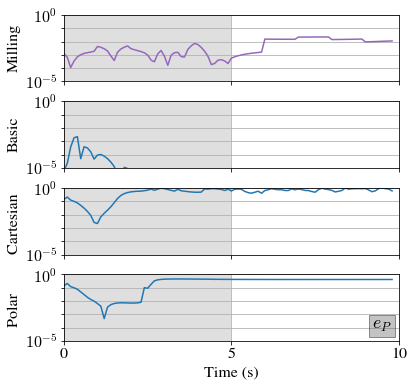

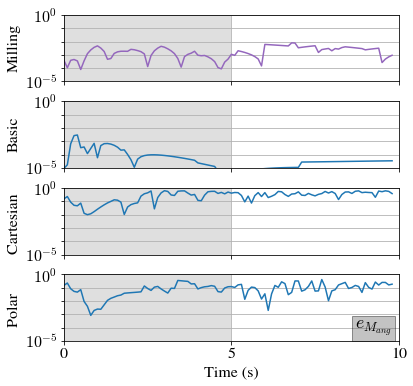

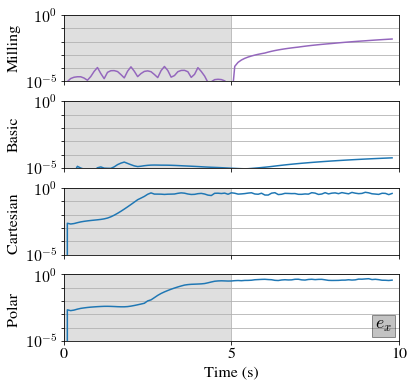

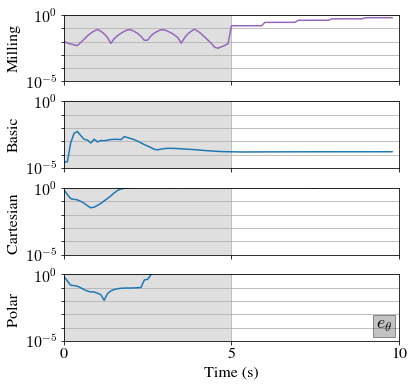

In [10]:
# Time-error plots Plots
T_start = 0
T_stop = 100
parameters = [ #[N,rho,dataype,method,eta,rs,re_init,waterfall,F,iterate_labels,name,milling,reinit,t_init]
    [100,2.5,13,'simple',0.08726646259971647,[1.],0,0,100,[r'$1$'],"Milling",1,0,0], 
    [10,16,13,'simple',0,[0.25],0,0,10,[r'$0.25$'],"Basic",0,0,0],
    [10,16,20,'FO_cartesian',0,[0.25],0,0,10,[r'$0.25$'],"Cartesian ",0,0,0],
    [10,16,21,'FO_polar',0,[0.25],0,0,10,[r'$0.25$'],"Polar ",0,0,0]
]
    
Pfig, Mfig, posfig, hfig = plot_errors(T_start, T_stop, parameters, wide,R,T_end,T_beg)

# Pfig.savefig('Results/AnalysisFigures/Polarisation', dpi=150,bbox_inches='tight')
# Mfig.savefig('Results/AnalysisFigures/AngularMomentum', dpi=150,bbox_inches='tight')
# posfig.savefig('Results/AnalysisFigures/Position', dpi=150,bbox_inches='tight')
# hfig.savefig('Results/AnalysisFigures/Heading', dpi=150,bbox_inches='tight')


vicsek_N10_eta0_W0_rho16_r025
swarmDMD_datatype13_N10_eta0_W0_rho16_r025_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
50
1
vicsek_N10_eta0_W0_rho16_r025
swarmDMD_datatype20_N10_eta0_W0_rho16_r025_R8_Tend50Tbeg0_methodFO_cartesian_T_start0_ReInit0_WF0
50
1
vicsek_N10_eta0_W0_rho16_r025
swarmDMD_datatype21_N10_eta0_W0_rho16_r025_R8_Tend50Tbeg0_methodFO_polar_T_start0_ReInit0_WF0
50
1


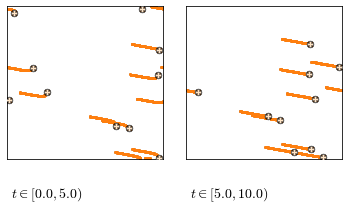

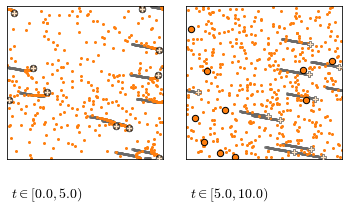

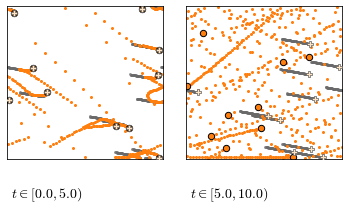

In [12]:
# Agent plots 
parameters = [ #[N,rho,dataype,method,eta,rs,re_init,waterfall,F,iterate_labels,name,milling,reinit,t_init]
#     [100,2.5,13,'simple',0.08726646259971647,[1.],0,0,100,[r'$1$'],"Milling",1,0], 
    [10,16,13,'simple',0,[0.25],0,0,10,[r'$0.25$'],"Basic",0,0,0],
    [10,16,20,'FO_cartesian',0,[0.25],0,0,10,[r'$0.25$'],"Cartesian ",0,0,0],
    [10,16,21,'FO_polar',0,[0.25],0,0,10,[r'$0.25$'],"Polar ",0,0,0]
]
T_start = 0
T_stop = 100

def PlotAgentSnapshot(T_start, T_stop, parameters,wide,R,T_end,T_beg):
    for parameter in parameters:
        reinit = parameter[12]
        T_init = parameter[13]

        N = parameter[0]
        rho  = parameter[1]
        datatype = parameter[2]
        method = parameter[3]
        eta = parameter[4]
        rs_used = parameter[5]
        re_init = parameter[6]
        waterfall = parameter[7]
        F = parameter[8]
        iterate_labels = parameter[9]
        name = parameter[10]
        milling = parameter[11]


        eta_name = str(eta).replace('.','')
        vert_bars = np.linspace(T_start,T_stop,3,dtype=int)[:-1]
        X_GT = np.zeros((2*N,len(vert_bars)))
        X_DMD = np.zeros((2*N,len(vert_bars),len(rs_used)))
        X_GT_tail = np.zeros((2*N,(T_stop-T_start)+1,len(rs_used)))
        X_DMD_tail = np.zeros((2*N,(T_stop-T_start)+1,len(rs_used)))

        i=0
        for r in rs_used:
            r_name = str(r).replace('.','')
            _,dt,_,TN,X_GT_temp,_,_,_,_,_,_,X_DMD_temp,_,_,_,_,_,_,_,_,_,_,_,_,_ = load_data(N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling)
            if milling:
                X_DMD_temp, X_GT_temp = recentre_milling(X_DMD_temp,X_GT_temp,8,3)
            X_GT = X_GT_temp[:,vert_bars]
            X_DMD[:,:,i] = X_DMD_temp[:,vert_bars]
            X_GT_tail[:,:,i] = X_GT_temp[:,:(T_stop-T_start)+1]
            X_DMD_tail[:,:,i] = np.copy(X_DMD_temp[:,:(T_stop-T_start)+1])
            i=i+1

        agent_plots = plot_agents_tails(X_GT_tail,X_DMD_tail,N,L,vert_bars,dt,rs_used)
#         agent_plots.savefig('Results/AnalysisFigures/AgentPositions'+millname+'_eta'+eta_name+'_r'+r_name+'_method'+method+'_Tstart'+str(T_start)+'_Tstop'+str(T_stop), dpi=150,bbox_inches='tight')

PlotAgentSnapshot(T_start, T_stop, parameters,wide,R,T_end,T_beg)

mDMDc_datatype20_S0_A50_eta02617993877991494_W0_rho16_r005_R8_Tend50Tbeg0_methodFO_cartesian_T_start0_ReInit0_WF0
300
mDMDc_datatype20_S0_A50_eta02617993877991494_W0_rho16_r005_R8_Tend50Tbeg0_methodFO_cartesian_T_start0_ReInit0_WF0
300
mDMDc_datatype20_S0_A50_eta02617993877991494_W0_rho16_r05_R8_Tend50Tbeg0_methodFO_cartesian_T_start0_ReInit0_WF0
300
mDMDc_datatype20_S0_A50_eta02617993877991494_W0_rho16_r05_R8_Tend50Tbeg0_methodFO_cartesian_T_start0_ReInit0_WF0
300


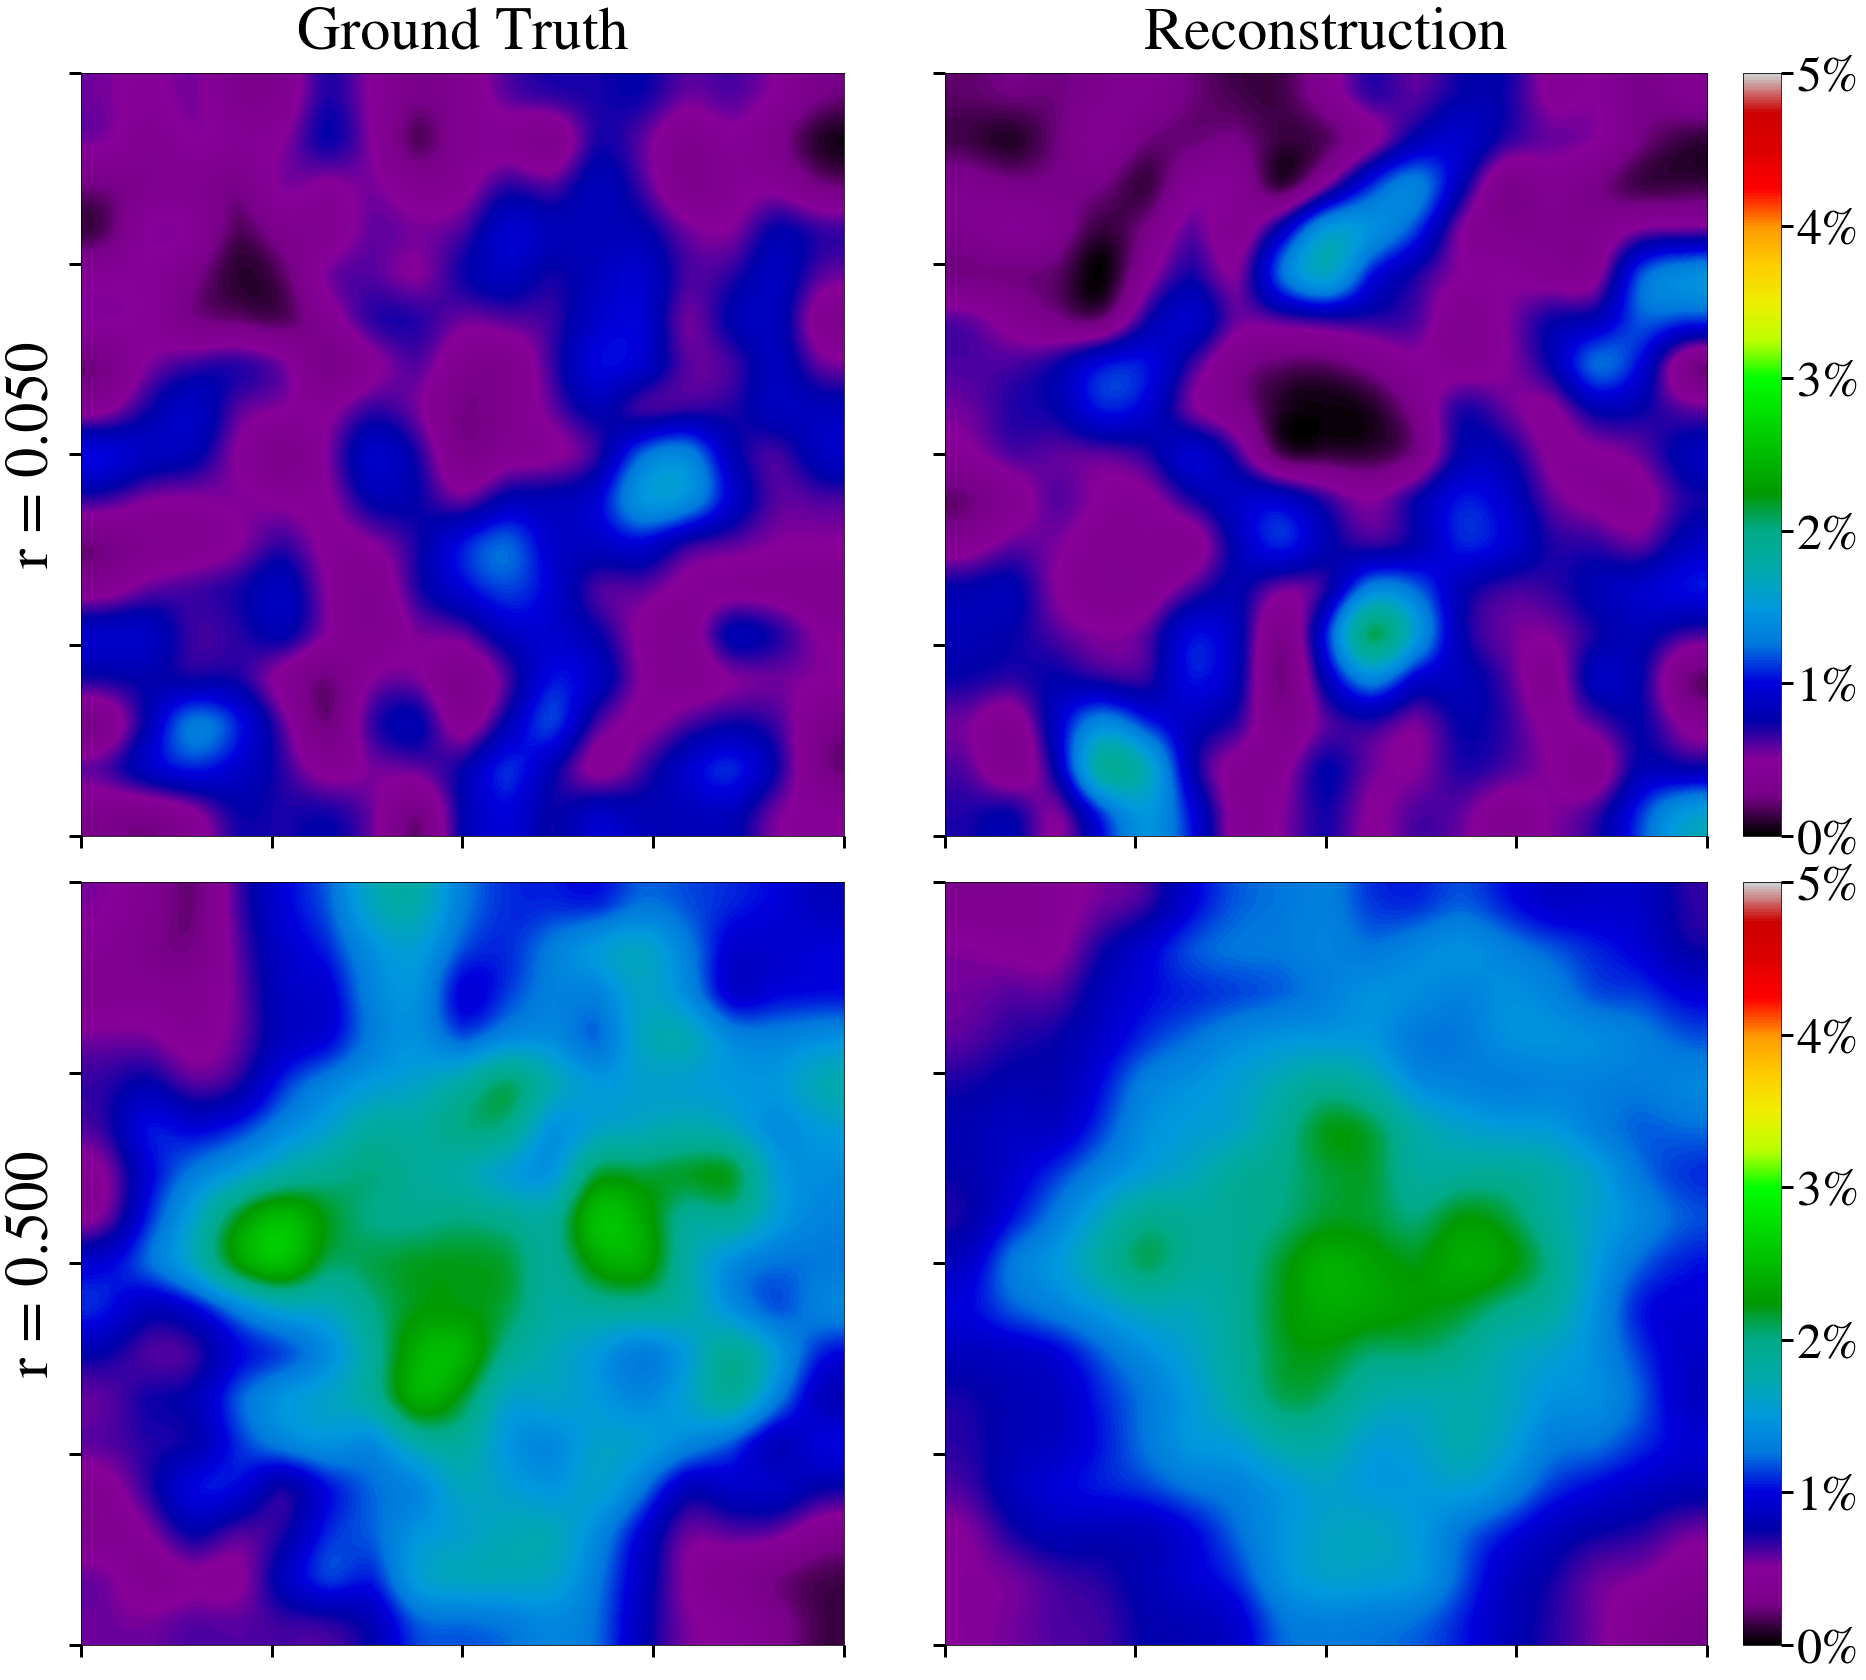

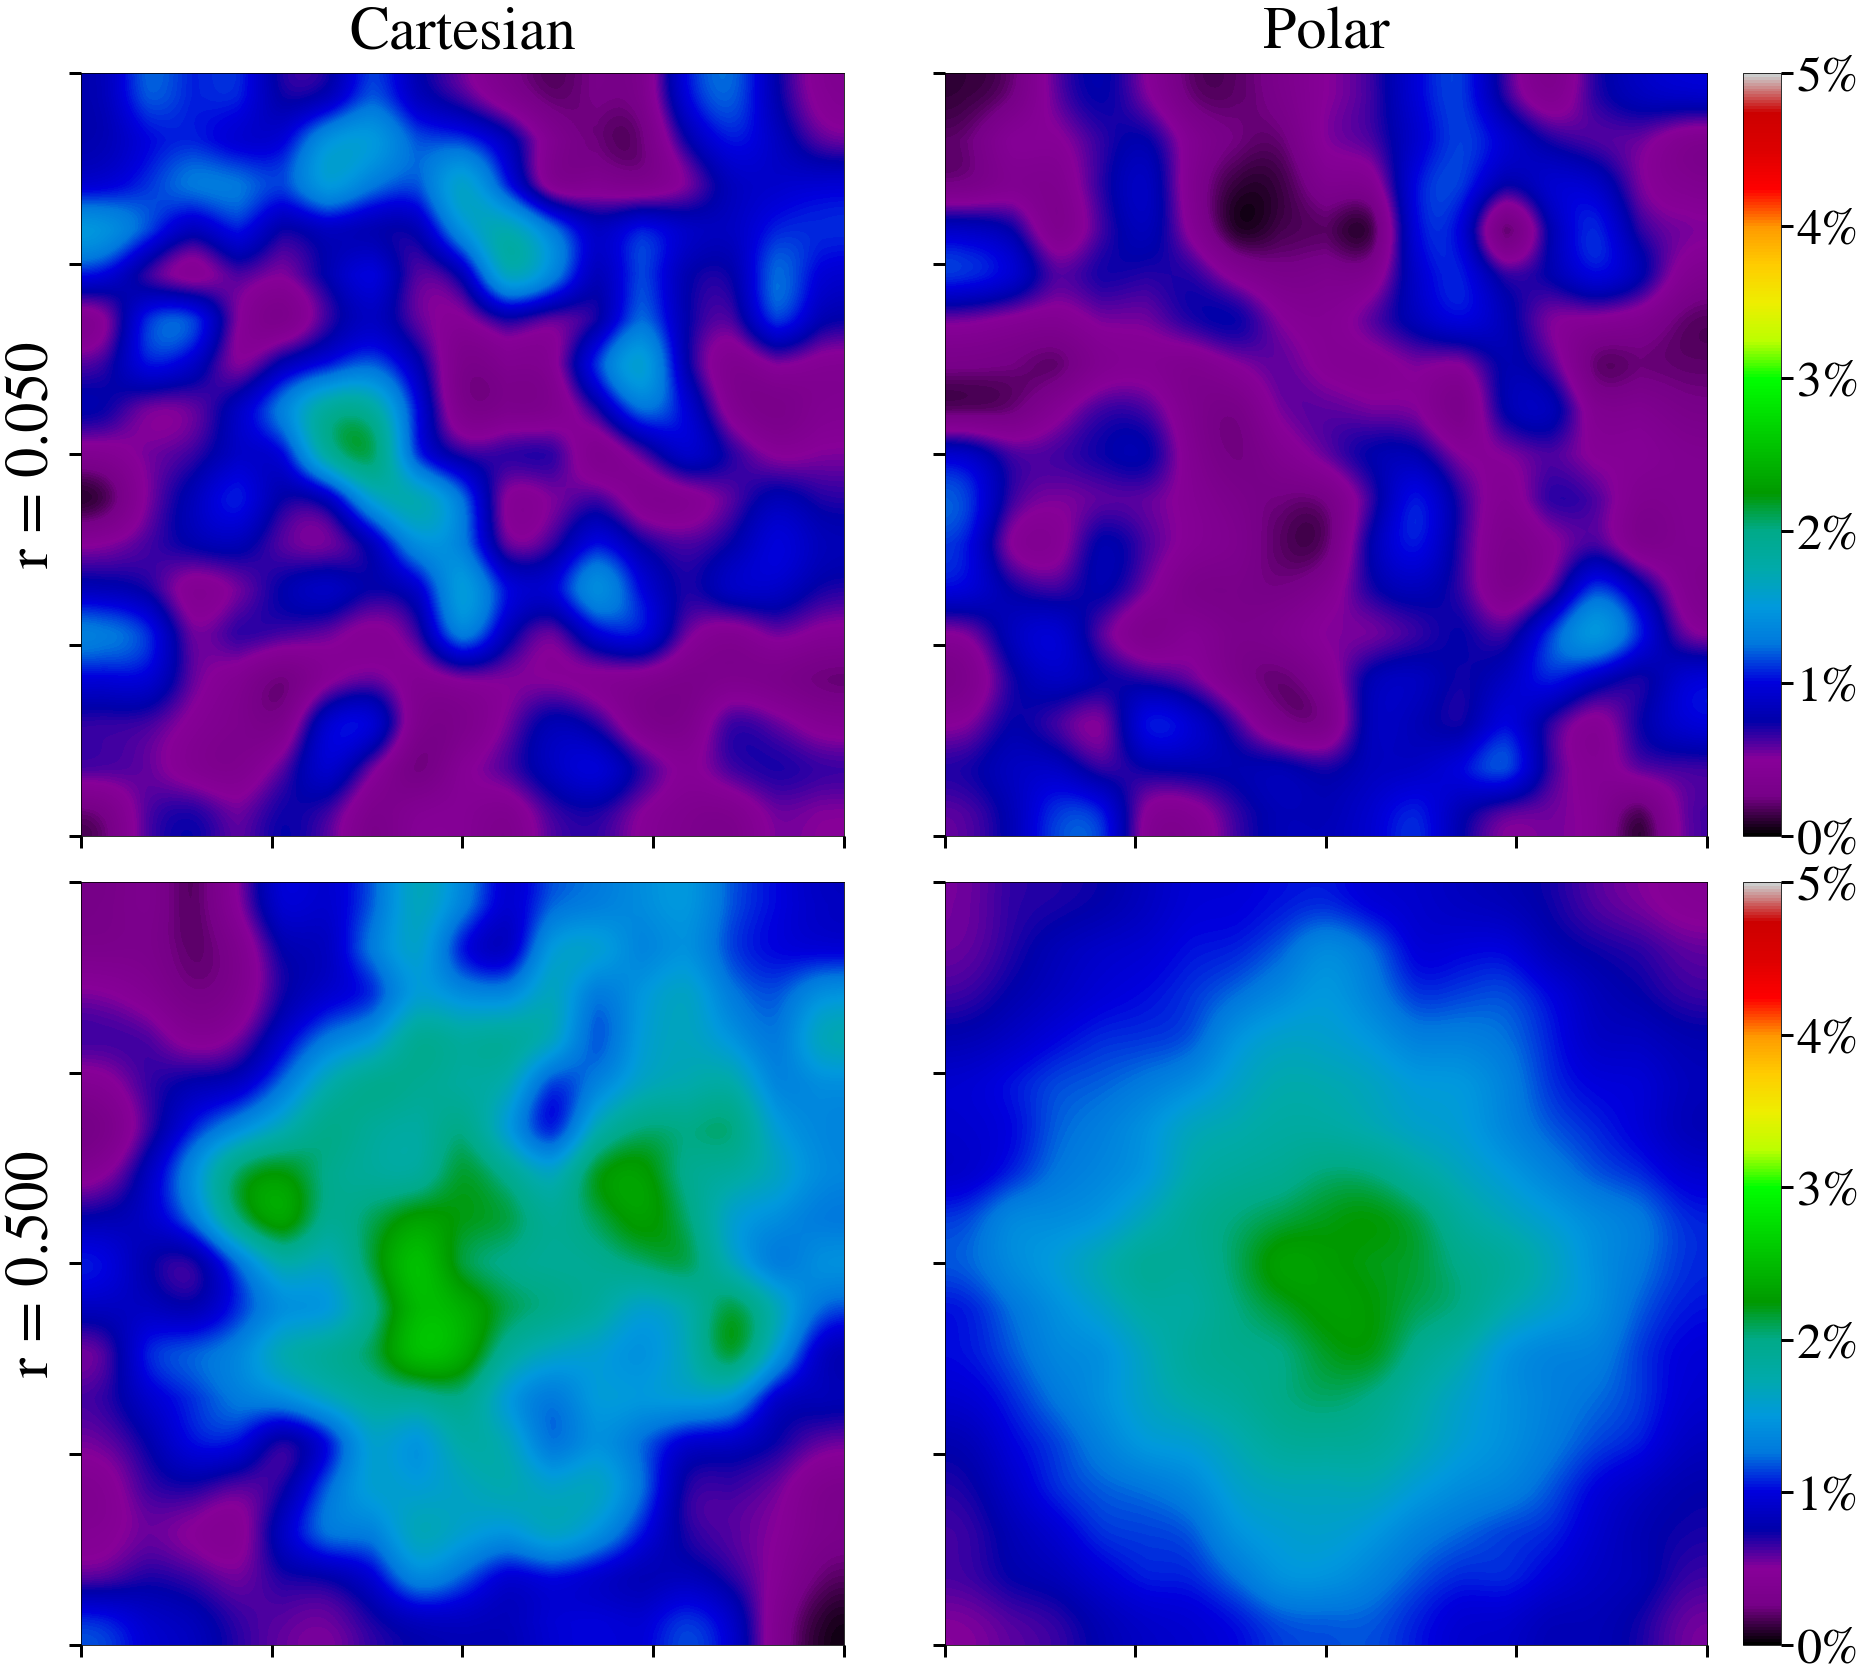

In [5]:
# Density Distribution Plots
rs = [0.2*r_av,2*r_av]
name = [['']*2]*(np.size(rs))
mean_bin = np.zeros((np.size(rs),2,17,17))
mean_bin_P = np.zeros((np.size(rs),2,17,17))
bins = np.zeros((np.size(rs),2,2,17,17))
r_minP = np.zeros(np.size(rs))
r_maxP = np.zeros(np.size(rs))
r_minT = np.zeros(np.size(rs))
r_maxT = np.zeros(np.size(rs))
domain = np.zeros((np.size(rs),3))

for i in range(np.size(rs)):
    maxT = 0
    maxP = 0
    minT = 500
    minP = 500
    j = 0
    r = rs[i]
    
    r_name = str(r).replace('.','')    
    _,_,_,_,_,_,_,_,_,bin_GT,bin_GT_P,_,_,_,_,_,_,_,num_bins,bin_width,bin_freq,train_zero_count,pred_zero_count,_,_ = load_data(N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling)
    bins[i,j,:,:,:] = np.meshgrid(np.linspace(0 - num_bins*bin_freq,0 + num_bins*bin_freq,2*num_bins+1),np.linspace(0 - num_bins*bin_freq,0 + num_bins*bin_freq,2*num_bins+1))
    mean_bin[i,j,:,:] = bin_GT/((T_end-T_beg)*F)
    mean_bin_P[i,j,:,:] = bin_GT_P/(T_pred*F)
    name[i][j] = f'GT, r = {np.round(copy.deepcopy(rs[i]),decimals=3)}'
    domain[i] = [-(num_bins*bin_freq + bin_width/2),0,(num_bins*bin_freq + bin_width/2)]
    
    if maxT < np.max(mean_bin[i][j]):
        maxT = np.max(mean_bin[i][j])
    if maxP < np.max(mean_bin_P[i][j]):
        maxP = np.max(mean_bin_P[i][j])
    if minT > np.min(mean_bin[i][j]):
        minT = np.min(mean_bin[i][j])
    if minP > np.min(mean_bin_P[i][j]):
        minP = np.min(mean_bin_P[i][j])
    
    for j in range(1,2):
        _,_,_,_,_,_,_,_,_,_,_,_,_,_,_,_,bin_DMD,bin_DMD_P,num_bins,bin_width,bin_freq,_,_,train_zero_count_DMD,pred_zero_count_DMD = load_data(N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling)
        mean_bin[i,j,:,:] = bin_DMD/((T_end-T_beg)*F)
        mean_bin_P[i,j,:,:] = bin_DMD_P/(T_pred*F)
        bins[i,j,:,:,:] = np.meshgrid(np.linspace(0 - num_bins*bin_freq,0 + num_bins*bin_freq,2*num_bins+1),np.linspace(0 - num_bins*bin_freq,0 + num_bins*bin_freq,2*num_bins+1))
        
        name[i][j] = 'DMD, r = {}'.format(np.round(copy.deepcopy(rs[i]),decimals=3))
        
        if maxT < np.max(mean_bin[i][j]):
            maxT = np.max(mean_bin[i][j])
        if maxP < np.max(mean_bin_P[i][j]):
            maxP = np.max(mean_bin_P[i][j])
        if minT > np.min(mean_bin[i][j]):
            minT = np.min(mean_bin[i][j])
        if minP > np.min(mean_bin_P[i][j]):
            minP = np.min(mean_bin_P[i][j])
    r_minP[i] = minP
    r_maxP[i] = maxP
    r_minT[i] = minT
    r_maxT[i] = maxT

# during training
fig = plt.figure(figsize=(25,23),constrained_layout=True)
grid = plt.GridSpec(np.size(rs), 2, figure=fig, hspace=0, wspace=-0.1)

axes = {}
caxes = {}
levels = []
for n in range(np.size(rs)):
    levels.append(np.linspace(0, r_maxT[n], 15))
    for m in range(2):
        axes[str(n)+str(m)] = fig.add_subplot(grid[n,m])


for n in range(np.size(rs)):
    for m in range(2):
        im = axes[str(n)+str(m)].imshow(mean_bin[n,m],extent=[-1,1,-1,1],cmap='nipy_spectral',interpolation= 'spline16',vmin = 0,vmax = 5)
        axes[str(n)+str(m)].tick_params(axis='x', labelsize=50)
        axes[str(n)+str(m)].tick_params(axis='y', labelsize=50)
        if n == 0:
            if m == 0:
                axes[str(n)+str(m)].set_title('Ground Truth',fontsize=60,y=1.0,pad=25)
            else:
                axes[str(n)+str(m)].set_title('Reconstruction',fontsize=60,y=1.0,pad=25)
        axes[str(n)+str(m)].set_xticklabels([])
        axes[str(n)+str(m)].set_yticklabels([])
        if m == 0:
            axes[str(n)+str(m)].set_ylabel('r = {:.3f}'.format(rs[n]),fontsize=60)
        else:
            axes[str(n)+str(m)].set_yticklabels([])
            
        axes[str(n)+str(m)].tick_params(axis='both',length=12,width=3)
    
    divider = make_axes_locatable(axes[str(n)+str(m)])
    cax = divider.append_axes("right", size="5%", pad=0.5)
    cbar = fig.colorbar(im, cax = cax)
    cbar.ax.tick_params(labelsize=50)
    cbar.ax.tick_params(labelsize=50, length=12,width=3)
    cbar.ax.set_yticklabels(['0%', '1%', '2%','3%','4%','5%'])
fig.savefig('Results/AnalysisFigures/DensityTraining'+millname+'_eta'+eta_name+'_method'+method, dpi=150,bbox_inches="tight")
    
# during prediction
figP = plt.figure(figsize=(25,23),constrained_layout=True)
gridP = plt.GridSpec(np.size(rs), 2, figure=figP, hspace=0, wspace=-0.1)

axesP = {}
levelsP = []
for n in range(np.size(rs)):
    levelsP.append(np.linspace(0, r_maxP[n], 15))
    for m in range(2):
        axesP[str(n)+str(m)] = figP.add_subplot(gridP[n,m])

for n in range(np.size(rs)):
    for m in range(2):
        imP = axesP[str(n)+str(m)].imshow(mean_bin_P[n,m],extent=[-1,1,-1,1],cmap='nipy_spectral',interpolation= 'spline16',vmin = 0,vmax = 5)
        axesP[str(n)+str(m)].tick_params(axis='x', labelsize=50)
        axesP[str(n)+str(m)].tick_params(axis='y', labelsize=50)
        if n == 0:
            if m == 0:
                axesP[str(n)+str(m)].set_title('Cartesian',fontsize=60,y=1.0,pad=25)
            else:
                axesP[str(n)+str(m)].set_title('Polar',fontsize=60,y=1.0,pad=25)
        axesP[str(n)+str(m)].set_xticklabels([])
        axesP[str(n)+str(m)].set_yticklabels([])
        if m == 0:
            axesP[str(n)+str(m)].set_ylabel('r = {:.3f}'.format(rs[n]),fontsize=60)
        else:
            axesP[str(n)+str(m)].set_yticklabels([])
        
        axesP[str(n)+str(m)].tick_params(axis='both',length=12,width=3)
                  
    dividerP = make_axes_locatable(axesP[str(n)+str(m)])
    caxP = dividerP.append_axes("right", size="5%", pad=0.5)
    cbarP = figP.colorbar(imP, cax = caxP)
    cbarP.ax.tick_params(labelsize=50, length=12,width=3)
    cbarP.ax.set_yticklabels(['0%', '1%', '2%','3%','4%','5%'])
figP.savefig('Results/AnalysisFigures/DensityPrediction'+millname+'_eta'+eta_name+'_method'+method, dpi=150,bbox_inches="tight")

In [59]:
# Data tables
N = 50
rho = 16
milling = 0
datatypes = [13,20,21]
methods = ['simple','FO_cartesian','FO_polar']
etas = [0,np.pi/12]
rs = [0.2*r_av,r_av,2*r_av,1]

error_table = np.zeros((len(methods)*(len(rs)-1)*len(etas)+1,11))
GT_table = np.zeros((len(methods)*(len(rs)-1)*len(etas)+1,7))

j=0
i = 0
for method in methods:
    datatype = datatypes[i]
    for r in rs:
        if r == 1 and datatype==13:
            etas = [0.08726646259971647]
            N = 200
            rho = 2.5
            milling = 1
            rs = [0.2*r_av,r_av,2*r_av]
            L = np.sqrt(1000/rho)
        else:
            etas = [0,np.pi/12]
            N = 50
            rho = 16
            milling = 0
            L = np.sqrt(N/rho)
        for eta in etas:
            r_name = str(r).replace('.','')
            eta_name = str(eta).replace('.','')
            _,dt,_,TN,X_GT0,_,P_GT0,Mang_GT0,_,_,_,X_DMD0,_,P_DMD0,Mang_DMD0,_,_,_,_,_,_,_,_,_,_ = load_data(N,eta_name,wide,rho,r_name,R,T_end,T_beg,F,datatype,method,T_init,re_init,waterfall,milling)
            _,_,pos_errs0 = ProcessData_StandardErrors(X_GT0,X_DMD0,L,N)
            time = np.arange(0,TN*30,dt)

            X_DMD_dot0 = position_difference(L,X_DMD0[:,:-1],X_DMD0[:,1:])/dt
            X_DMD_heading0 = np.arctan2(X_DMD_dot0[N:,:],X_DMD_dot0[:N,:])
            X_GT_dot0 = position_difference(L,X_GT0[:,:-1],X_GT0[:,1:])/dt
            X_GT_heading0 = np.arctan2(X_GT_dot0[N:,:],X_GT_dot0[:N,:])
            h_diff = np.absolute(X_DMD_heading0-X_GT_heading0)
            h_errs0 = np.mean(np.minimum(h_diff, 2*np.pi - h_diff), axis=0)

            Mang_errs0 = np.absolute(Mang_GT0-Mang_DMD0)
            P_errs0 = np.absolute(P_GT0-P_DMD0)
    
            t_P = np.inf if np.max(P_errs0[T_end:]>1e-01)==False else time[np.argmax(P_errs0[T_end:]>1e-01)]
            t_Mang = np.inf if np.max(Mang_errs0[T_end:]>1e-01)==False else time[np.argmax(Mang_errs0[T_end:]>1e-01)]
            t_pos = np.inf if np.max((pos_errs0[T_end:]/L)>1e-01)==False else time[np.argmax((pos_errs0[T_end:]/L)>1e-01)]
            t_h = np.inf if np.max(h_errs0[T_end:]>1e-01)==False else time[np.argmax(h_errs0[T_end:]>1e-01)]

            error_table[j,:] = [datatype,r,eta,t_pos,t_h,t_P,t_Mang,np.mean(pos_errs0[:50]/L),np.mean(h_errs0[:50]),np.mean(P_errs0[:50]),np.mean(Mang_errs0[:50])]
            GT_table[j,:] = [datatype,r,eta,np.mean(P_GT0[:50]),np.mean(Mang_GT0[:50]),np.mean(P_GT0[50:100]),np.mean(Mang_GT0[50:100])]
            
            j=j+1
    i=i+1
            
np.savetxt("errors.csv", error_table, delimiter=",")
np.savetxt("GT.csv", GT_table, delimiter=",")

mDMDc_datatype13_S0_A50_eta0_W0_rho16_r005_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r005_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype13_S0_A50_eta0_W0_rho16_r025_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r025_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype13_S0_A50_eta0_W0_rho16_r05_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype13_S0_A50_eta02617993877991494_W0_rho16_r05_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype13_S0_A200_eta008726646259971647_W0_rho2.5_r1_R8_Tend50Tbeg0_methodsimple_T_start0_ReInit0_WF0_milling
300
(200, 299, 2)
mDMDc_datatype20_S0_A50_eta0_W0_rho16_r005_R8_Tend50Tbeg0_methodFO_cartesian_T_start0_ReInit0_WF0
300
(50, 299, 2)
mDMDc_datatype20_S0_A50_eta02617993877991494_W0_rh